# Linear Regression

## Summary

- Univariate linear regression
- Analytical approach: normal equation
- Iterative approach: gradient descent
- Multivariate linear regression
- Polynomial regression
- Regularization

## Univariate linear regression

### Linear regression in a nutshell

A linear regression model searches for a linear relationship between inputs (features) and output (target).

[![Linear Regression example](images/linear_regression.png)](https://en.wikipedia.org/wiki/Linear_regression)

### Example: using a linear model to predict country happiness

(Inspired by [Homemade Machine Learning](https://github.com/trekhleb/homemade-machine-learning) by Oleksii Trekhleb)

The [World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness#2017.csv) ranks 155 countries by their happiness levels. Several economic and social indicators (GDP, degree of freedom, level of corruption...) are recorded for each country.

Can a linear model accurately predict country happiness based on these indicators ?

### Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import pandas as pd

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = "retina"
sns.set()

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

In [3]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error

scikit-learn version: 0.22.1


### Data loading and analysis

In [4]:
# Load World Happiness Report for 2017
dataset_url = "https://raw.githubusercontent.com/bpesquet/mlhandbook/master/_datasets/world-happiness-report-2017.csv"
df_happiness = pd.read_csv(dataset_url)

# Print dataset shape (rows and columns)
print(f"Dataset shape: {df_happiness.shape}")

Dataset shape: (155, 12)


In [5]:
# Print a concise summary of the dataset
df_happiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        155 non-null    object 
 1   Happiness.Rank                 155 non-null    int64  
 2   Happiness.Score                155 non-null    float64
 3   Whisker.high                   155 non-null    float64
 4   Whisker.low                    155 non-null    float64
 5   Economy..GDP.per.Capita.       155 non-null    float64
 6   Family                         155 non-null    float64
 7   Health..Life.Expectancy.       155 non-null    float64
 8   Freedom                        155 non-null    float64
 9   Generosity                     155 non-null    float64
 10  Trust..Government.Corruption.  155 non-null    float64
 11  Dystopia.Residual              155 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 

In [6]:
# Show the 10 first samples
df_happiness.head(n=10)

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182
5,Netherlands,6,7.377,7.427426,7.326574,1.503945,1.428939,0.810696,0.585384,0.470490,0.282662,2.294804
6,Canada,7,7.316,7.384403,7.247597,1.479204,1.481349,0.834558,0.611101,0.435540,0.287372,2.187264
7,New Zealand,8,7.314,7.379510,7.248490,1.405706,1.548195,0.816760,0.614062,0.500005,0.382817,2.046456
8,Sweden,9,7.284,7.344095,7.223905,1.494387,1.478162,0.830875,0.612924,0.385399,0.384399,2.097538
9,Australia,10,7.284,7.356651,7.211349,1.484415,1.510042,0.843887,0.601607,0.477699,0.301184,2.065211


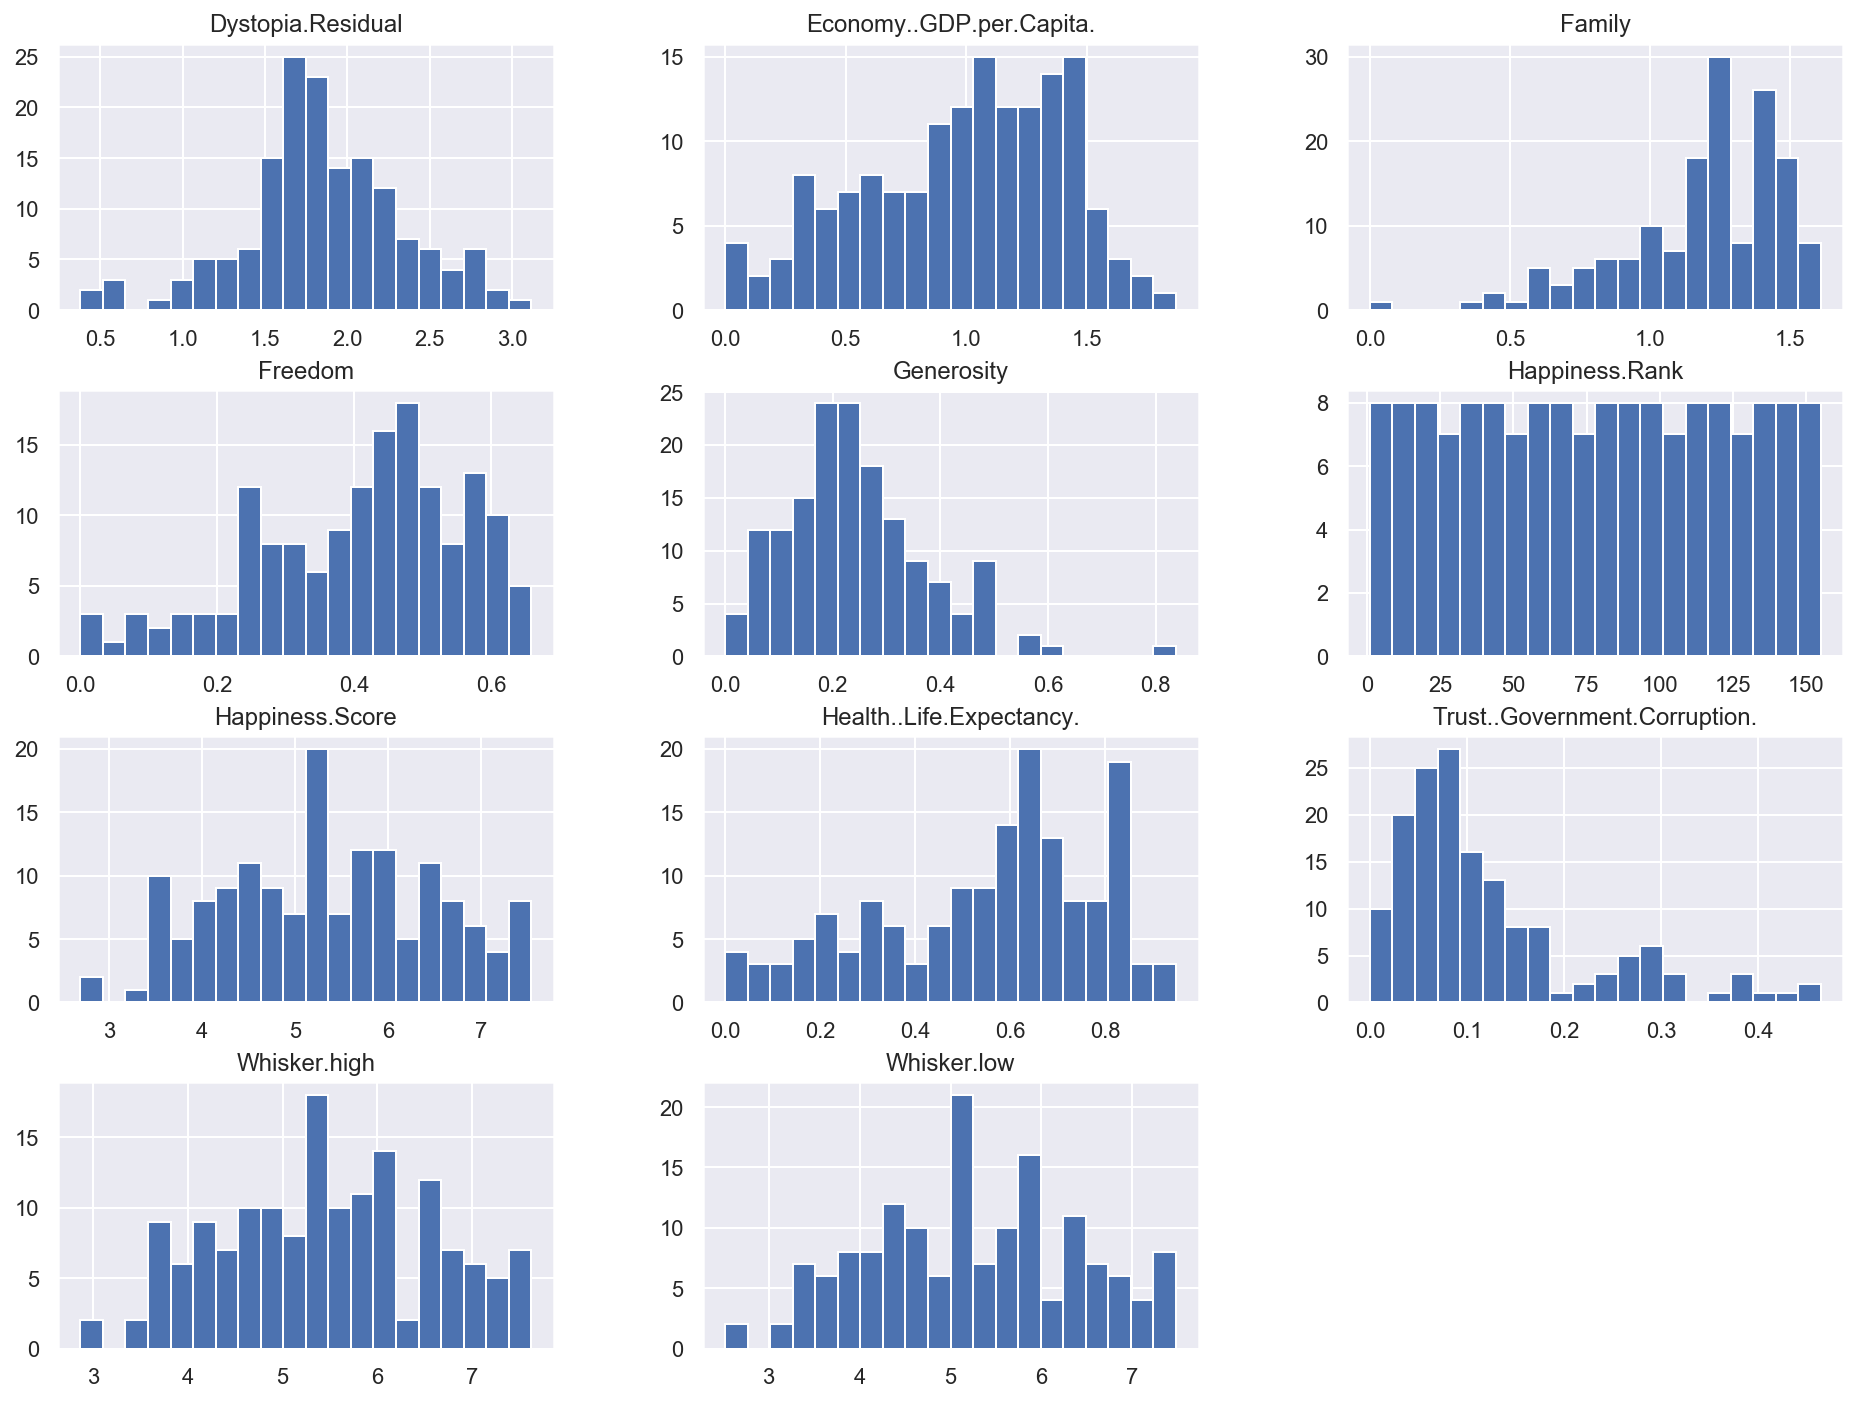

In [7]:
# Plot histograms for all numerical attributes
df_happiness.hist(bins=20, figsize=(16, 12))
plt.show()

### Data splitting

In [8]:
def split_dataset(df_data, input_features, target_feature):
    """Split dataset between training and test sets, keeping only selected features"""
    
    df_train, df_test = train_test_split(df_happiness, test_size=0.2)

    print(f"Training dataset: {df_train.shape}")
    print(f"Test dataset: {df_test.shape}")

    x_train = df_train[input_features].to_numpy()
    y_train = df_train[target_feature].to_numpy()

    x_test = df_test[input_features].to_numpy()
    y_test = df_test[target_feature].to_numpy()

    print(f"Training data: {x_train.shape}, labels: {y_train.shape}")
    print(f"Test data: {x_test.shape}, labels: {y_test.shape}")

    return x_train, y_train, x_test, y_test

In [9]:
# Define GDP as sole input feature
input_features_uni = ["Economy..GDP.per.Capita."]
# Define happiness as target
target_feature = "Happiness.Score"

x_train_uni, y_train_uni, x_test_uni, y_test_uni = split_dataset(
    df_happiness, input_features_uni, target_feature
)

Training dataset: (124, 12)
Test dataset: (31, 12)
Training data: (124, 1), labels: (124,)
Test data: (31, 1), labels: (31,)


### Data plotting

In [10]:
def plot_univariate(x, y, input_features, target_features, model=None):
    """2D plot of features and target, including model prediction if defined"""
    
    plt.scatter(x, y, label="Actual")
    
    if model is not None:
        predictions_count = 100
        x_pred = np.linspace(x.min(), x.max(), predictions_count).reshape(predictions_count, 1);
        y_pred = model.predict(x_pred)
        plt.plot(x_pred, y_pred, 'r', label='Prediction')
    
    plt.xlabel(input_features)
    plt.ylabel(target_feature)
    plt.title('Countries Happiness')
    plt.legend()

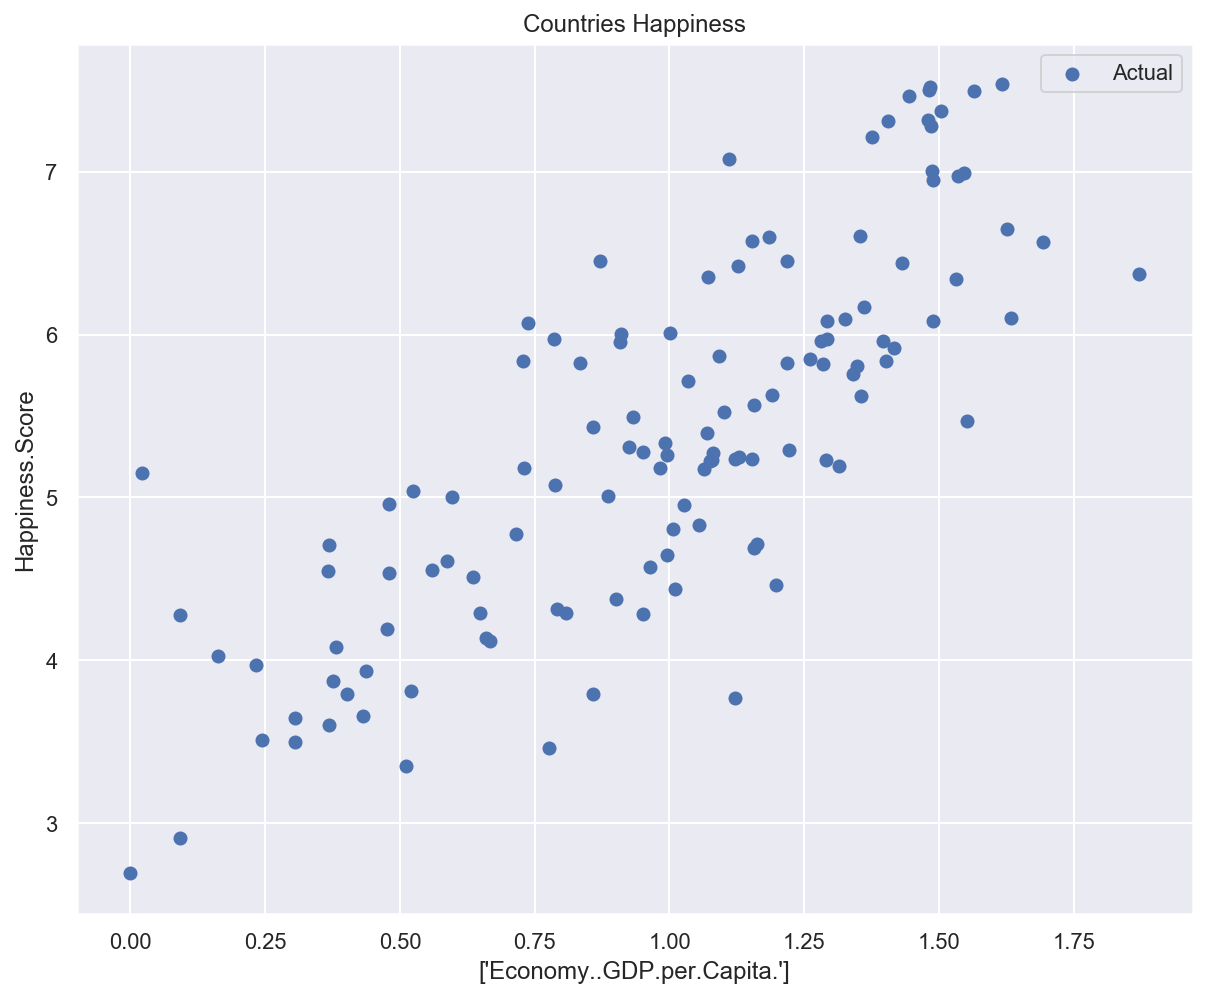

In [11]:
# Plot training data
plot_univariate(x_train_uni, y_train_uni, input_features_uni, target_feature)

### Problem formulation

- $\pmb{x}^{(i)}$: $i$th data sample, vector of $n+1$ features $x^{(i)}_j$ with $x^{(i)}_0 = 1$.
- $\pmb{\theta}$: parameters of the linear model, vector of $n+1$ values $\theta_j$.
- $\mathcal{h}_\theta$: hypothesis function (relationship between inputs and targets).
- $y'^{(i)}$: model output for the $i$th sample.

$$\pmb{x}^{(i)} = \begin{pmatrix}
       \ x^{(i)}_0 \\
       \ x^{(i)}_1 \\
       \ \vdots \\
       \ x^{(i)}_n
     \end{pmatrix} \in \pmb{R}^{n+1}
\;\;\;
\pmb{\theta} = \begin{pmatrix}
       \ \theta_0 \\
       \ \theta_1 \\
       \ \vdots \\
       \ \theta_n
     \end{pmatrix} \in \pmb{R}^{n+1}$$

$$y'^{(i)} = \mathcal{h}_\theta(x^{(i)}) = \theta_0 + \theta_1x^{(i)}_1 + \dotsc + \theta_nx^{(i)}_n = \pmb{\theta}^T\pmb{x}^{(i)}$$

### Loss function

Mean Squared Error (MSE):

$$\mathcal{L}(\theta) = \frac{1}{m}\sum_{i=1}^m (y'^{(i)} - y^{(i)})^2 = \frac{1}{m}\sum_{i=1}^m (\pmb{\theta}^T \pmb{x}^{(i)} - y^{(i)})^2$$

Find $\hat{\theta}$ so that $\frac{\mathcal{L}(\theta)}{d\theta} = 0$ in order to minimize loss.

Solution: $\hat{\theta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y$ [(math proof)](https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression/)

## Analytical approach: normal equation

- $\pmb{X}$: matrix of input data. Each line corresponds to a data sample.
- $\pmb{y}$: vector of target values.

$$\pmb{X} = \begin{bmatrix}
       \ x^{(0)T} \\
       \ x^{(1)T} \\
       \ \vdots \\
       \ x^{(m)T} \\
     \end{bmatrix} =
\begin{bmatrix}
       \ x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_n \\
       \ x^{(2)}_0 & x^{(2)}_1 & \cdots & x^{(2)}_n \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ x^{(m)}_0 & x^{(m)}_1 & \cdots & x^{(m)}_n
     \end{bmatrix}\;\;\;
\pmb{y} = \begin{pmatrix}
       \ y^{(1)} \\
       \ y^{(2)} \\
       \ \vdots \\
       \ y^{(m)}
     \end{pmatrix}$$
     
$$\pmb{X}\pmb{\theta} =
\begin{pmatrix}
       \ \theta_0 + \theta_1x^{(1)}_1 + \dotsc + \theta_nx^{(1)}_n \\
       \ \theta_0 + \theta_1x^{(2)}_1 + \dotsc + \theta_nx^{(2)}_n \\
       \ \vdots \\
       \ \theta_0 + \theta_1x^{(m)}_1 + \dotsc + \theta_nx^{(m)}_n
     \end{pmatrix} = 
\begin{pmatrix}
       \ \mathcal{h}_\theta(x^{(1)}) \\
       \ \mathcal{h}_\theta(x^{(2)}) \\
       \ \vdots \\
       \ \mathcal{h}_\theta(x^{(m)})
     \end{pmatrix}$$

### Scalar square

$$\pmb{v} = \begin{pmatrix}
       \ v_1 \\
       \ v_2 \\
       \ \vdots \\
       \ v_n
     \end{pmatrix} \text{ (column vector)}$$

$$\sum_{i=1}^n v_i^2 = \pmb{v}^T \pmb{v}$$

$$\mathcal{L}(\theta) = \frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(x^{(i)}) - y^{(i)})^2 = \frac{1}{m}(\pmb{X}\pmb{\theta} - \pmb{y})^T(\pmb{X}\pmb{\theta} - \pmb{y})$$

$$\mathcal{L}(\theta) = \frac{1}{m}((\pmb{X}\pmb{\theta})^T - \pmb{y}^T)(\pmb{X}\pmb{\theta} - \pmb{y}) = \frac{1}{m}((\pmb{X}\pmb{\theta})^T\pmb{X}\pmb{\theta} - (\pmb{X}\pmb{\theta})^T\pmb{y} - \pmb{y}^T(\pmb{X}\pmb{\theta}) + \pmb{y}^T\pmb{y})$$

Since $\pmb{X}\pmb{\theta}$ and $\pmb{y}$ are column vectors, $(\pmb{X}\pmb{\theta})^T\pmb{y} = \pmb{y}^T(\pmb{X}\pmb{\theta})$.

$$\mathcal{L}(\theta) = \frac{1}{m}(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} - 2(\pmb{X}\pmb{\theta})^T\pmb{y} + \pmb{y}^T\pmb{y})$$

We must find the $\pmb{\theta^*}$ vector that minimizes the loss function $\mathcal{L}(\theta)$.

$$\pmb{\theta^*} = \underset{\theta}{\mathrm{argmin}}\;\mathcal{L}(\theta)$$

Since the loss function is continuous, convex and differentiable everywhere (in simplest termes: bowl-shaped), it admits one unique global minimum, for which the gradient vector $\nabla_{\theta}\mathcal{L}(\pmb{\theta})$ is equal to $\vec{0}$.

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \mathcal{L}(\boldsymbol{\theta})
     \end{pmatrix} = \nabla_{\theta}\left(\frac{1}{m}(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} - 2(\pmb{X}\pmb{\theta})^T\pmb{y} + \pmb{y}^T\pmb{y})\right)$$

Since $\pmb{y}^T\pmb{y}$ is constant w.r.t. $\pmb{\theta}$, $\nabla_{\theta}(\pmb{y}^T\pmb{y}) = \vec{0}$.

Reminder: $\forall i \in [1..m], x_0^{(i)} = 1$.

$$2(\pmb{X}\pmb{\theta})^T\pmb{y} = 2\;\begin{pmatrix}
       \ \theta_0 + \theta_1x^{(1)}_1 + \dotsc + \theta_nx^{(1)}_n \\
       \ \theta_0 + \theta_1x^{(2)}_1 + \dotsc + \theta_nx^{(2)}_n \\
       \ \vdots \\
       \ \theta_0 + \theta_1x^{(m)}_1 + \dotsc + \theta_nx^{(m)}_n
     \end{pmatrix}^T\begin{pmatrix}
       \ y^{(1)} \\
       \ y^{(2)} \\
       \ \vdots \\
       \ y^{(m)}
     \end{pmatrix} = 2\sum_{i=1}^m y^{(i)}(\theta_0 + \theta_1x^{(i)}_1 + \dotsc + \theta_nx^{(i)}_n) 
     = 2\sum_{i=1}^m y^{(i)}\sum_{j=0}^n x_j^{(i)}\theta_j$$
     
$$\nabla_{\theta}\left(2(\pmb{X}\pmb{\theta})^T\pmb{y}\right) = 
\begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \left(2(\pmb{X}\pmb{\theta})^T\pmb{y}\right)  \\
       \ \frac{\partial}{\partial \theta_1} \left(2(\pmb{X}\pmb{\theta})^T\pmb{y}\right) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \left(2(\pmb{X}\pmb{\theta})^T\pmb{y}\right)
     \end{pmatrix} =
2\begin{pmatrix}
       \ \sum_{i=1}^m y^{(i)}x_0^{(i)} \\
       \ \sum_{i=1}^m y^{(i)}x_1^{(i)} \\
       \ \vdots \\
       \ \sum_{i=1}^m y^{(i)}x_n^{(i)}
     \end{pmatrix} = 2 \pmb{X}^T\pmb{y}$$

$\pmb{X}^T\pmb{X}$ is a square and symmetric matrix called $\pmb{A}$ here for simplicity of notation.

$$\pmb{X}^T\pmb{X} = \begin{bmatrix}
       \ x^{(1)}_0 & x^{(2)}_0 & \cdots & x^{(m)}_0 \\
       \ x^{(1)}_1 & x^{(2)}_1 & \cdots & x^{(m)}_1 \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ x^{(1)}_n & x^{(2)}_n & \cdots & x^{(m)}_n
     \end{bmatrix}
\begin{bmatrix}
       \ x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_n \\
       \ x^{(2)}_0 & x^{(2)}_1 & \cdots & x^{(2)}_n \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ x^{(m)}_0 & x^{(m)}_1 & \cdots & x^{(m)}_n
     \end{bmatrix} = \pmb{A} \in \pmb{R}^{n+1 \times n+1}$$

$$\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} = \begin{pmatrix}
       \ \theta_0 \\
       \ \theta_1 \\
       \ \vdots \\
       \ \theta_n
     \end{pmatrix}^T
     \begin{bmatrix}
       \ a_{00} & a_{01} & \cdots & a_{0n} \\
       \ a_{10} & a_{11} & \cdots & a_{1n} \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ a_{n0} & a_{n1} & \cdots & a_{nn}
     \end{bmatrix}
     \begin{pmatrix}
       \ \theta_0 \\
       \ \theta_1 \\
       \ \vdots \\
       \ \theta_n
     \end{pmatrix} = 
     \begin{pmatrix}
       \ \theta_0 \\
       \ \theta_1 \\
       \ \vdots \\
       \ \theta_n
     \end{pmatrix}^T
     \begin{pmatrix}
       \ a_{00}\theta_0 + a_{01}\theta_1 + \dotsc + a_{0n}\theta_n \\
       \ a_{10}\theta_0 + a_{11}\theta_1 + \dotsc + a_{1n}\theta_n \\
       \ \vdots \\
       \ a_{n0}\theta_0 + a_{n1}\theta_1 + \dotsc + a_{nn}\theta_n
     \end{pmatrix}$$
     
$$\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} = \theta_0(a_{00}\theta_0 + a_{01}\theta_1 + \dotsc + a_{0n}\theta_n) + \theta_1(a_{10}\theta_0 + a_{11}\theta_1 + \dotsc + a_{1n}\theta_n) + \dotsc + \theta_n(a_{n0}\theta_0 + a_{n1}\theta_1 + \dotsc + a_{nn}\theta_n)$$

$$\frac{\partial}{\partial \theta_0} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right) =
2a_{00}\theta_0 + a_{01}\theta_1 + \dotsc + a_{0n}\theta_n + a_{10}\theta_1 + a_{20}\theta_2 + \dotsc + a_{n0}\theta_n$$

Since $\pmb{A}$ is symmetric, $\forall i,j \in [1..n,1..n], a_{ij} = a_{ji}$.

$$\frac{\partial}{\partial \theta_0} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right) =
2(a_{00}\theta_0 + a_{01}\theta_1 + \dotsc + a_{0n}\theta_n) =
2\sum_{j=0}^n a_{0j}\theta_j$$

$$\nabla_{\theta}\left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right)=
\begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right)  \\
       \ \frac{\partial}{\partial \theta_1} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \left(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta}\right)
     \end{pmatrix} =
     2\begin{pmatrix}
       \ \sum_{j=0}^n a_{0j}\theta_j  \\
       \ \sum_{j=0}^n a_{1j}\theta_j \\
       \ \vdots \\
       \ \sum_{j=0}^n a_{nj}\theta_j
     \end{pmatrix}=
     2\pmb{A}\pmb{\theta} = 2\pmb{X}^T\pmb{X}\pmb{\theta}$$

We can finally express the gradient of the loss function w.r.t. the model parameters:

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \nabla_{\theta}\left(\frac{1}{m}(\pmb{\theta}^T\pmb{X}^T\pmb{X}\pmb{\theta} - 2(\pmb{X}\pmb{\theta})^T\pmb{y} + \pmb{y}^T\pmb{y})\right) = \frac{1}{m}\left(2\pmb{X}^T\pmb{X}\pmb{\theta} - 2\pmb{X}^T\pmb{y}\right) = \frac{2}{m}\pmb{X}^T\left(\pmb{X}\pmb{\theta} - y\right)$$

The $\pmb{\theta^*}$ vector that minimizes the loss is such as:

$$\pmb{X}^T\pmb{X}\pmb{\theta^{*}} = \pmb{X}^T\pmb{y}$$

If $\pmb{X}^T\pmb{X}$ is an inversible matrix, the result is given by:

$$\pmb{\theta^{*}} = (\pmb{X}^T\pmb{X})^{-1}\pmb{X}^T\pmb{y}$$

This is called the **Normal Equation**.

In [25]:
# Return RMSE for a model and a training set
def compute_error(model, x, y_true):
    # Compute model predictions for a dataset
    y_pred = model.predict(x)

    # Compute the error between actual and expected results
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [13]:
def train_model(model, x, y):
    model.fit(x, y)
    print(f"Weight: {model.coef_}. Bias: {model.intercept_}")

    rmse_train = compute_error(model, x, y)
    print(f"Training error: {rmse_train:.05f}")


def test_model(model, x, y):
    rmse_test = compute_error(model, x, y)
    print(f"Test error: {rmse_test:.05f}")

In [14]:
lr_model = LinearRegression()

train_model(lr_model, x_train_uni, y_train_uni)
test_model(lr_model, x_test_uni, y_test_uni)

Weight: [2.14701196]. Bias: 3.2398524806199123
Training error: 0.68015
Test error: 0.55818


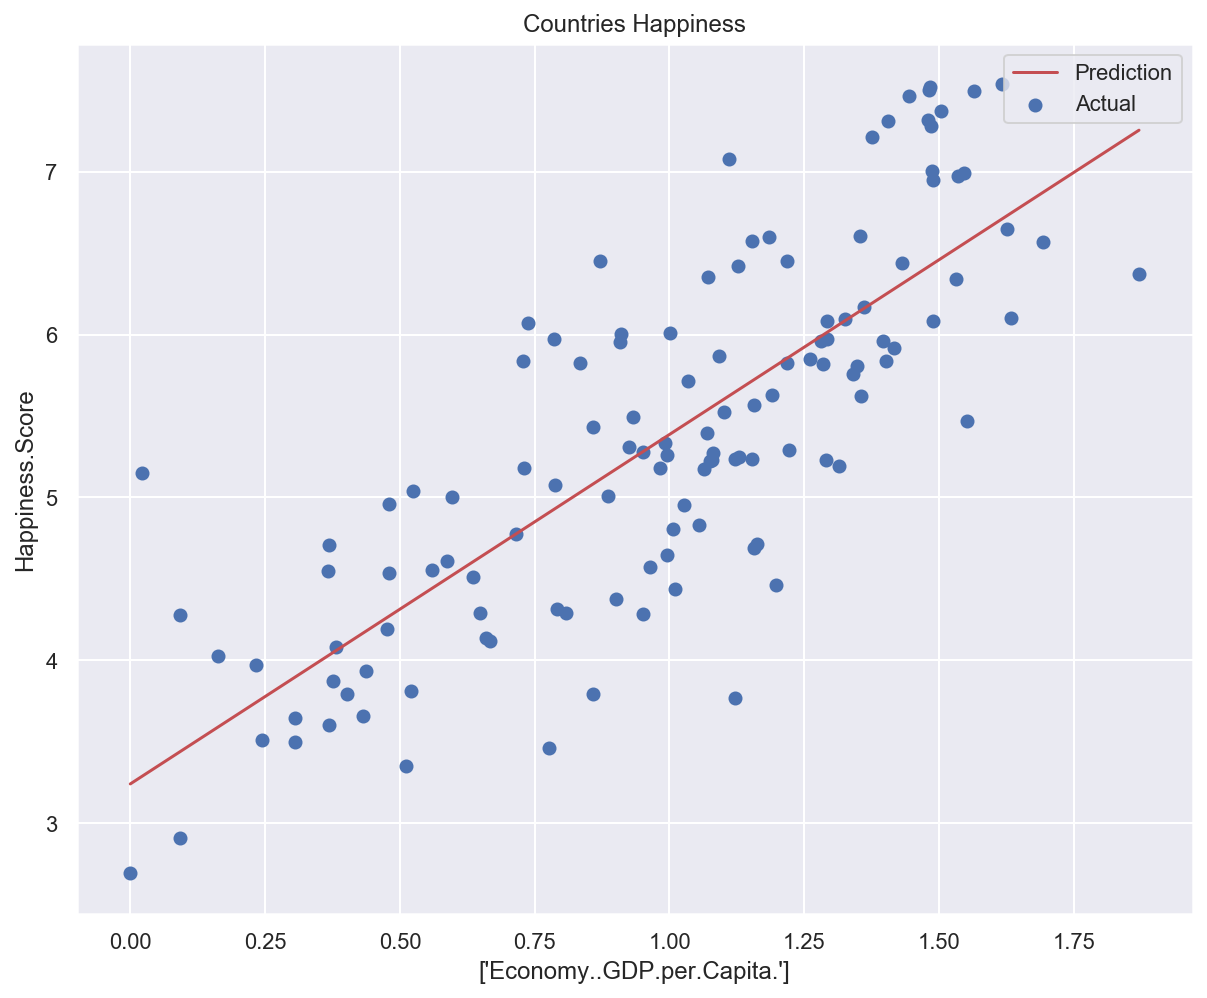

In [15]:
plot_univariate(x_train_uni, y_train_uni, input_features_uni, target_feature, lr_model)

In [16]:
sgd_model_uni = SGDRegressor()

train_model(sgd_model_uni, x_train_uni, y_train_uni)
test_model(sgd_model_uni, x_test_uni, y_test_uni)

Weight: [2.58568426]. Bias: [2.76539209]
Training error: 0.70520
Test error: 0.56777


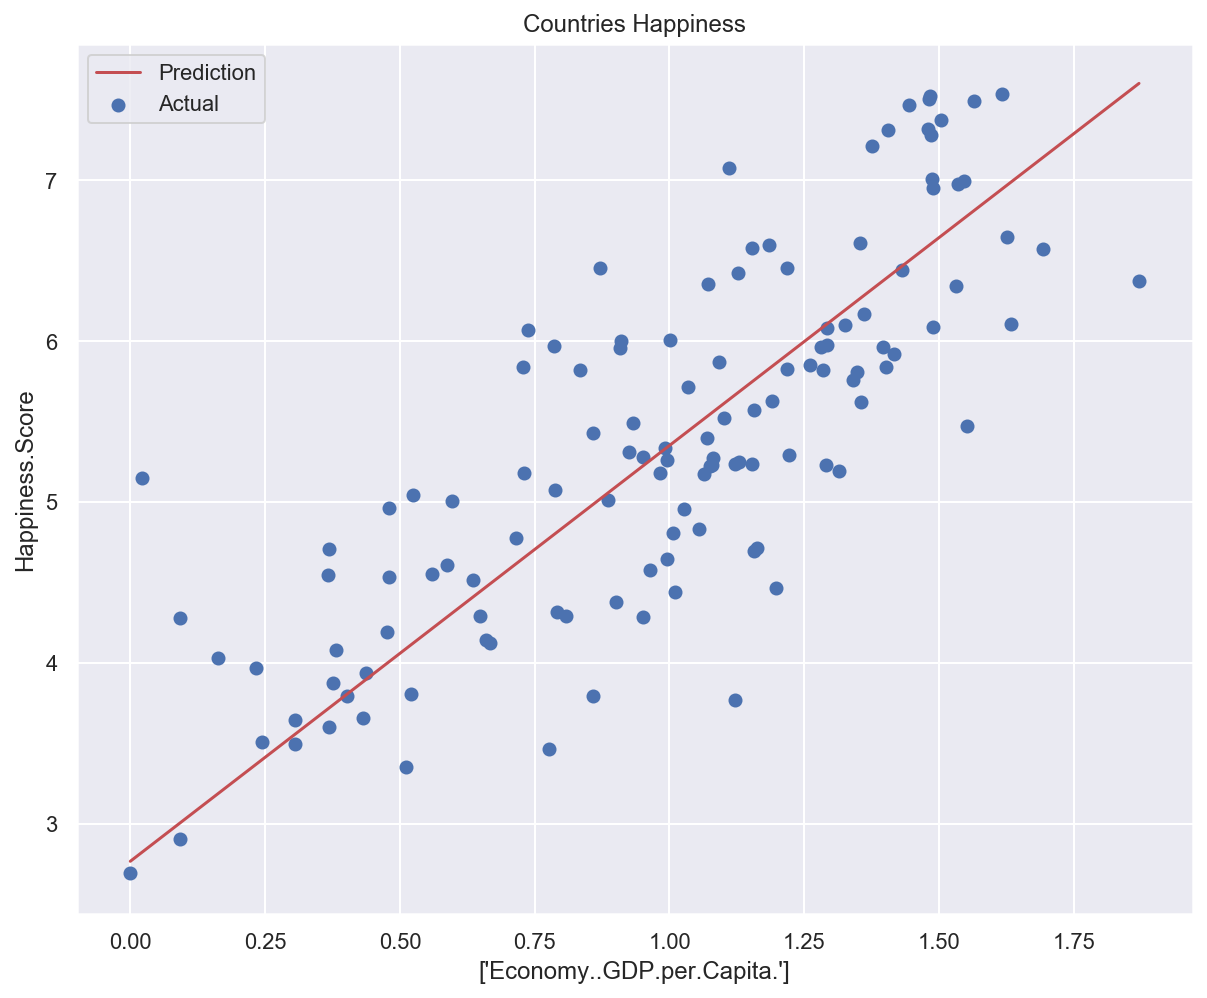

In [17]:
plot_univariate(x_train_uni, y_train_uni, input_features_uni, target_feature, sgd_model_uni)

In [18]:
input_features_multi = ["Economy..GDP.per.Capita.", "Freedom"]

x_train_multi, y_train_multi, x_test_multi, y_test_multi = split_dataset(
    df_happiness, input_features_multi, target_feature
)

Training dataset: (124, 12)
Test dataset: (31, 12)
Training data: (124, 2), labels: (124,)
Test data: (31, 2), labels: (31,)


In [19]:
def plot_multivariate(x, y, input_features, target_features, model=None):
    # Configure the plot with training dataset
    plot_training_trace = go.Scatter3d(
        x=x[:, 0].flatten(),
        y=x[:, 1].flatten(),
        z=y.flatten(),
        name="Actual",
        mode="markers",
        marker={
            "size": 10,
            "opacity": 1,
            "line": {"color": "rgb(255, 255, 255)", "width": 1},
        },
    )

    plot_data = plot_training_trace

    if model is not None:
        # Generate different combinations of X and Y sets to build a predictions plane.
        predictions_count = 10

        # Find min and max values along X and Y axes.
        x_min = x[:, 0].min()
        x_max = x[:, 0].max()

        y_min = x[:, 1].min()
        y_max = x[:, 1].max()

        # Generate predefined numbe of values for eaxh axis betwing correspondent min and max values.
        x_axis = np.linspace(x_min, x_max, predictions_count)
        y_axis = np.linspace(y_min, y_max, predictions_count)

        # Create empty vectors for X and Y axes predictions
        # We're going to find cartesian product of all possible X and Y values.
        x_pred = np.zeros((predictions_count * predictions_count, 1))
        y_pred = np.zeros((predictions_count * predictions_count, 1))

        # Find cartesian product of all X and Y values.
        x_y_index = 0
        for x_index, x_value in enumerate(x_axis):
            for y_index, y_value in enumerate(y_axis):
                x_pred[x_y_index] = x_value
                y_pred[x_y_index] = y_value
                x_y_index += 1

        # Predict Z value for all X and Y pairs.
        z_pred = model.predict(np.hstack((x_pred, y_pred)))

        # Plot training data with predictions.

        # Configure the plot with test dataset.
        plot_predictions_trace = go.Scatter3d(
            x=x_pred.flatten(),
            y=y_pred.flatten(),
            z=z_pred.flatten(),
            name="Prediction Plane",
            mode="markers",
            marker={"size": 1,},
            opacity=0.8,
            surfaceaxis=2,
        )

        plot_data = [plot_training_trace, plot_predictions_trace]

    # Configure the layout.
    plot_layout = go.Layout(
        title="Date Sets",
        scene={
            "xaxis": {"title": input_features[0]},
            "yaxis": {"title": input_features[1]},
            "zaxis": {"title": target_feature},
        },
        margin={"l": 0, "r": 0, "b": 0, "t": 0},
    )

    plot_figure = go.Figure(data=plot_data, layout=plot_layout)

    # Render 3D scatter plot.
    plotly.offline.iplot(plot_figure)

In [20]:
plot_multivariate(x_train_multi, y_train_multi, input_features_multi, target_feature)

In [21]:
sgd_model_multi = SGDRegressor()

train_model(sgd_model_multi, x_train_multi, y_train_multi)
test_model(sgd_model_multi, x_test_multi, y_test_multi)

Weight: [2.33431606 1.10270348]. Bias: [2.53889871]
Training error: 0.61273
Test error: 0.61114


In [22]:
plot_multivariate(x_train_multi, y_train_multi, input_features_multi, target_feature, sgd_model_multi)

## Analytical approach

- Technique for computing the regression coefficients $\theta_i$ analytically (by calculus).
- One-step learning algorithm (no iterations).
- Also called *Ordinary Least Squares*.

## Pros/cons of analytical approach

Pros:

- Computed in one step.
- Exact solution.

Cons:

- Computation of $(X^T \cdot X)^{-1}$ is slow when the number of features is large ($n > 10^4$).
- Problem if $X^T \cdot X$ is not inversible.


## Iterative approach: gradient descent

- Same objective: find $\hat{\theta}$ that minimizes loss.
- General idea:
  - Start with random values for the $\theta$ vector.
  - Update $\theta$ in small steps towards the loss minimum.
- To know in which direction update $\theta$, we compute the **gradient** of the loss function w.r.t. $\theta$ and go into the opposite direction.

[![Gradient descent line graph](images/gradient_descent_line_graph.gif)](https://alykhantejani.github.io/a-brief-introduction-to-gradient-descent/)

## Computation of gradients

$\mathcal{L}(\theta) = \frac{1}{m}\sum_{i=1}^m (\theta^T\cdot x^{(i)} - y^{(i)})^2$

$\frac{\partial}{\partial \theta_j} \mathcal{L}(\theta) = \frac{2}{m}\sum_{i=1}^m (\theta^T\cdot x^{(i)} - y^{(i)})x^{(i)}_j$

$$\nabla_{\theta}\mathcal{L}(\theta) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\theta) \\
       \ \frac{\partial}{\partial \theta_2} \mathcal{L}(\theta) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \mathcal{L}(\theta)
     \end{pmatrix} =
\frac{2}{m}X^T\cdot (X\cdot \theta - y)$$

## Parameters update

The **_learning rate_** $\eta$ governs the amplitude of updates.

$$\theta_{next} = \theta - \eta\nabla_{\theta}\mathcal{L}(\theta)$$

[![Importance of learning rate](images/learning_rate.png)](https://www.jeremyjordan.me/nn-learning-rate/)

## Types of gradient descent

- *Batch*: use the whole dataset to compute gradients.
  - Safe but potentially slow.
- *Stochastic*: use only one sample.
  - Fast but potentially erratic.
- *Mini-Batch*: use a small set of samples (10-1000).
  - Good compromise.

## Pros/cons of iterative approach

Pros:

- Works well with a large number of features.
- MSE loss convex => guarantee of a global minimum.

Cons:

- Convergence depends on learning rate and GD type.
- Dependant on feature scaling.

## Polynomial Regression

- How can a linear model fit non-linear data?
- Solution: add powers of each feature as new features.
- The hypothesis function is still linear.

[![Polynomial degree examples](images/polynomial_regression.png)](https://github.com/ageron/handson-ml2)

## Regularization

- Solution against overfitting: constraining model parameters.

- Ridge regression (using L2 norm): $\mathcal{L}(\theta) = MSE(\theta) + \frac{\lambda}{2}\sum_{i=1}^n \theta_i^2$

- Lasso regression (using L1 norm): $\mathcal{L}(\theta) = MSE(\theta) + \lambda\sum_{i=1}^n |\theta_i|$

- $\lambda$ is called the **regularization rate**.

## Effects of regularization rate

(Called $\alpha$ here)

Left: linear model. Right: 10th degree polynomial model.

[![Ridge regression example](images/ridge_regression.png)](https://github.com/ageron/handson-ml2)
